<a href="https://colab.research.google.com/github/topaz0828/deeplearning/blob/master/2020451108_%EC%A1%B0%ED%98%84%EC%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://www-prima.inrialpes.fr/perso/Gourier/Faces/HeadPoseImageDatabase.tar.gz
!tar -xvzf HeadPoseImageDatabase.tar.gz
!echo "test!!"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Person02/person02143+0-45.txt
Person02/person02191+60+90.jpg
Person02/person02224-30+60.jpg
Person02/person02218-30-30.jpg
Person02/person02243+0-45.txt
Person02/person02123-30+45.txt
Person02/person02146+0+0.jpg
Person02/person02172+30+0.jpg
Person02/person02149+0+45.jpg
Person02/person02163+15+60.jpg
Person02/person02183+60-30.txt
Person02/person02212-60+75.jpg
Person02/person02119-30-15.jpg
Person02/person02161+15+30.txt
Person02/person02281+60-60.jpg
Person02/person02166+30-90.jpg
Person02/person02230-15-45.txt
Person02/person02206-60-15.txt
Person02/person02170+30-30.jpg
Person02/person02206-60-15.jpg
Person02/person02202-60-75.jpg
Person02/person02268+30-60.txt
Person02/person02106-60-15.txt
Person02/person02228-15-75.jpg
Person02/person02101-60-90.txt
Person02/person02219-30-15.txt
Person02/person02225-30+75.txt
Person02/person02157+15-30.jpg
Person02/person02275+30+45.txt
Person02/person02277+30+75.jpg
Person02/person02204-60-45.jpg
Person02/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import math
import cv2
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, ZeroPadding2D,BatchNormalization, Activation, MaxPooling2D, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import utils
from tensorflow.keras import Input

import tensorflow as tf
import os
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

# ********************************************************
#               HeadPoseImageDatabase
# ********************************************************

person_list = sorted(glob.glob('Person*')) # search the folders starting with 'Person'

img_list = []
for i in range(len(person_list)):
    img_list.extend(glob.glob(os.path.join(person_list[i], '*.jpg'))) # save all the image filenames to img_list

del person_list

#split data for OOM issue fixed
train_person = ['Person01','Person02','Person03','Person04','Person05','Person06','Person07','Person08','Person09','Person10','Person11','Person12','Person13','Person14']
test_person = ['Person15']

train_list = []
test_list = []

for i, path in enumerate(img_list):
  if path[:8] in train_person:
    train_list.append(path)
  elif path[:8] in test_person:
    test_list.append(path)

In [ ]:
# ********************************************************
#          LOAD AND RESIZE TRAIN DATA FROM DATABAE
# ********************************************************

Train_N = len(train_list)  #Read train number of list
resize_target = (144, 192) #Original/2 for Resize
X_train = np.zeros((Train_N, 144, 192, 3))  # {numpy} -> shape : [2604, 144, 192, 3]
Y_train = np.zeros((Train_N, 4))  # {numpy} -> shape : [2604, 4]

for i, img_file in enumerate(train_list):
      img = cv2.imread(img_file, cv2.IMREAD_COLOR)  # read the image file
      txt_file = img_file[:-4] + '.txt'  # take the txt file address from the image file address
      with open(txt_file, 'r') as f:
          line = f.read().splitlines()
          center_x = int(line[3])
          center_y = int(line[4])
          width = int(line[5])
          height = int(line[6])  # open the text file and take the face box information from it

      #resize img and bounding box
      x1, x2, y1,y2 = int(center_x-width//2), int(center_x+width//2) ,int(center_y-height//2), int(center_y+height//2) 
      ia_bounding_box = ia.BoundingBox(x1=x1, x2=x2, y1=y1, y2=y2)
      image_rescaled = ia.imresize_single_image(img, resize_target)
      bb_rescaled = ia_bounding_box.project(img.shape,image_rescaled.shape)

      X_train[i] = image_rescaled
      Y_train[i] = bb_rescaled.x1, bb_rescaled.x2, bb_rescaled.y1, bb_rescaled.y2 

print("Train Image Load and Resize Complete, Loaded Train Data : ", Train_N)

Train Image Load and Resize Complete, Loaded Train Data :  2604


In [ ]:
# ********************************************************
#          LOAD AND RESIZE TEST DATA FROM DATABAE
# ********************************************************

Test_N = len(test_list) #Read test number of list
X_test = np.zeros((Test_N, 144, 192, 3))  # same shape with train data
Y_test = np.zeros((Test_N, 4)) # 186

for i, img_file in enumerate(test_list):
      img = cv2.imread(img_file, cv2.IMREAD_COLOR)  # read the image file
      txt_file = img_file[:-4] + '.txt'  # take the txt file address from the image file address
      with open(txt_file, 'r') as f:     # open the text file and take the face box information from it
          line = f.read().splitlines()
          center_x = int(line[3])
          center_y = int(line[4])
          width = int(line[5])
          height = int(line[6])  

      #resize img and bounding box
      x1, x2, y1,y2 = int(center_x-width//2), int(center_x+width//2) ,int(center_y-height//2), int(center_y+height//2) 
      ia_bounding_box = ia.BoundingBox(x1=x1, x2=x2, y1=y1, y2=y2)
      image_rescaled = ia.imresize_single_image(img, resize_target)
      bb_rescaled = ia_bounding_box.project(img.shape,image_rescaled.shape)

      X_test[i] = image_rescaled
      Y_test[i] = bb_rescaled.x1, bb_rescaled.x2, bb_rescaled.y1, bb_rescaled.y2
print("Test Image Load and Resize Complete, Loaded Train Data : ", Test_N)

Test Image Load and Resize Complete, Loaded Train Data :  186


In [ ]:
#type change
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
y_train =Y_train.astype('float32')
y_test = Y_test.astype('float32')

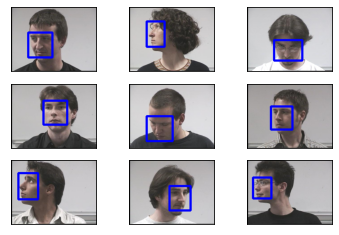

In [ ]:
# ********************************************************
#    CHECK TRAIN DATASET
# ********************************************************
 
fig = plt.figure()
ims = np.random.randint(Train_N, size=9)

for i in range(9):
    subplot = fig.add_subplot(3,3, i+1)
    sample_idx = ims[i]
    sample = x_train[sample_idx].copy()  # copy the image to sample ( not to affect the original data )
    sample_bbx = y_train[sample_idx]

    sample_x1 = int(sample_bbx[0])
    sample_x2 = int(sample_bbx[1])
    sample_y1 = int(sample_bbx[2])
    sample_y2 = int(sample_bbx[3]) # get box info from Y
 
    cv2.rectangle(sample, (sample_x1, sample_y1), (sample_x2, sample_y2), (255, 0, 0), (3))
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(cv2.cvtColor(sample.astype('uint8'), cv2.COLOR_BGR2RGB))
 
plt.show()

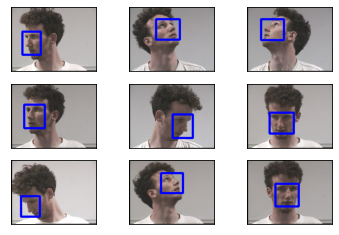

In [ ]:
# ********************************************************
#    CHECK TEST DATASET
# ********************************************************
 
fig = plt.figure()
ims = np.random.randint(Test_N, size=9)

for i in range(9):
    subplot = fig.add_subplot(3,3, i+1)
    sample_idx = ims[i]
    sample = x_test[sample_idx].copy()  # copy the image to sample ( not to affect the original data )
    sample_bbx = y_test[sample_idx]

    sample_x1 = int(sample_bbx[0])
    sample_x2 = int(sample_bbx[1])
    sample_y1 = int(sample_bbx[2])
    sample_y2 = int(sample_bbx[3]) # get box info from Y
 
    cv2.rectangle(sample, (sample_x1, sample_y1), (sample_x2, sample_y2), (255, 0, 0), (3))
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(cv2.cvtColor(sample.astype('uint8'), cv2.COLOR_BGR2RGB))
 
plt.show()

In [ ]:
# ********************************************************
#          DATA AUGMENTATION (DATA DOUBLE)
# ********************************************************

ia.seed(20200618)

x_train_aug = np.zeros_like(x_train)
y_train_aug = np.zeros_like(y_train)

#AUG Profile Set
seq = iaa.Sequential([
      iaa.Multiply((0.8, 1.5)),
      iaa.Affine(translate_percent={"x": 5, "y":5}, scale=(0.8,0.9))
])

#Make AUG
for idx in range(Test_N):
  bbx = BoundingBox(x1= y_train[idx][0], x2= y_train[idx][1], y1 = y_train[idx][2], y2 = y_train[idx][3])
  bbx = [bbx]
  bbx = BoundingBoxesOnImage(bbx, x_train[idx].shape)
  image_aug, bbs_aug = seq(image= x_train[idx], bounding_boxes=bbx)
  x_train_aug[idx] = image_aug
  y_train_aug[idx] = bbs_aug.bounding_boxes[0].x1, bbs_aug.bounding_boxes[0].x2, bbs_aug.bounding_boxes[0].y1, bbs_aug.bounding_boxes[0].y2

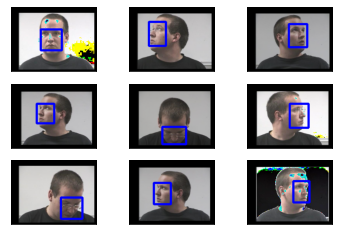

In [ ]:
# ********************************************************
#      CHECK AUG DATASET
# ********************************************************
 
fig = plt.figure()
ims = np.random.randint(Test_N, size=9)

for i in range(9):
    subplot = fig.add_subplot(3,3, i+1)
    sample_idx = i
    sample = x_train_aug[sample_idx].copy()  # copy the image to sample ( not to affect the original data )
    sampe_y = y_train_aug[sample_idx]

    sample_x1 = int(sampe_y[0])
    sample_x2 = int(sampe_y[1])
    sample_y1 = int(sampe_y[2])
    sample_y2 = int(sampe_y[3]) # get box info from Y
    
    cv2.rectangle(sample, (sample_x1, sample_y1), (sample_x2, sample_y2), (255, 0, 0), (3))
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(cv2.cvtColor(sample.astype('uint8'), cv2.COLOR_BGR2RGB))

plt.show()

In [ ]:
# ********************************************************
#     DATA COMBINE AND DELETE FOR MEMORY
# ********************************************************

mixed_xtrain = np.zeros((Train_N*2, 144, 192, 3))
mixed_ytrain = np.zeros((Train_N*2, 4))

for i in range(Train_N) :
  mixed_xtrain[i] = x_train[i]
  mixed_ytrain[i] = y_train[i]

for i in range(Train_N) :
  mixed_xtrain[Train_N+i] = x_train_aug[i]
  mixed_ytrain[Train_N+i] = y_train_aug[i]

del x_train, x_train_aug, y_train, y_train_aug, X_train, Y_train
x_train = mixed_xtrain
y_train = mixed_ytrain
del mixed_xtrain, mixed_ytrain

In [ ]:
# ********************************************************
#          NORMALIZATION AND SHAPE CHECK
# ********************************************************

# Convert class vectors to binary class matrices.
(train_num, h, w, channum) = x_train.shape
(test_num, _, _, _) = x_test.shape
(_, outputdim) = y_train.shape

#Normalize 
x_train /= 255
x_test /= 255

mean = y_train.mean(axis=0)
std = y_train.std(axis=0)
y_train = (y_train - mean) / std
y_test = (y_test - mean) / std

In [ ]:
# ********************************************************
#          WEIGHT SAVE ON GOOGLE DRIVE
# ********************************************************
from google.colab import drive
drive.mount('/content/drive')
filepath="/content/drive/My Drive/Colab Notebooks/traing/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', verbose=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# *************************************************************
#               Model building (RESNET50)
# *************************************************************

# Training Parameters
epochs = 200
batch_size = 16
num_classes = outputdim

def build_network(h, w, channum):
    input_tensor = Input(shape=(h, w, channum), dtype='float32', name='input')
    def conv1_layer(x):
        x = ZeroPadding2D(padding=(3, 3))(x)
        x = Conv2D(64, (7, 7), strides=(2, 2))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        return x
    def conv2_layer(x):
        x = MaxPooling2D((3, 3), 2)(x)
        for i in range(3):
            shortcut = x
            if (i == 0):
                x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
                shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)
                x = BatchNormalization()(x)
                shortcut = BatchNormalization()(shortcut)

                x = Add()([x, shortcut])
                x = Activation('relu')(x)

            else:
                x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)

                x = Add()([x, shortcut])
                x = Activation('relu')(x)

        return x


    def conv3_layer(x):
        for i in range(4):
            shortcut = x
            if (i == 0):
                x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
                shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
                x = BatchNormalization()(x)
                shortcut = BatchNormalization()(shortcut)

                x = Add()([x, shortcut])
                x = Activation('relu')(x)
            else:
                x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)

                x = Add()([x, shortcut])
                x = Activation('relu')(x)
        return x

    def conv4_layer(x):
        for i in range(6):
            shortcut = x
            if (i == 0):
                x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
                shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
                x = BatchNormalization()(x)
                shortcut = BatchNormalization()(shortcut)

                x = Add()([x, shortcut])
                x = Activation('relu')(x)

            else:
                x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)

                x = Add()([x, shortcut])
                x = Activation('relu')(x)
        return x

    def conv5_layer(x):
        for i in range(3):
            shortcut = x
            if (i == 0):
                x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
                shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
                x = BatchNormalization()(x)
                shortcut = BatchNormalization()(shortcut)

                x = Add()([x, shortcut])
                x = Activation('relu')(x)

            else:
                x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)

                x = Add()([x, shortcut])
                x = Activation('relu')(x)
        return x

    x = conv1_layer(input_tensor)
    x = conv2_layer(x)
    x = conv3_layer(x)
    x = conv4_layer(x)
    x = conv5_layer(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(100, activation='relu') (x)
    x = Dropout(0.2) (x)

    output_tensor = Dense(num_classes, activation='linear')(x)

    resnet50 = models.Model(input_tensor, output_tensor)
    resnet50.summary()
    return resnet50

model = build_network(h,w,channum)

model.compile(optimizer=optimizers.Adam(lr=0.001),
              loss='mean_squared_error', metrics=['mse', 'mae'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 144, 192, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 150, 198, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 72, 96, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 72, 96, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
# ********************************************************
#               Training 
# ********************************************************

history = model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[cp_callback],
                    verbose=1, shuffle=True)
history_dict = history.history
history_dict.keys()

Epoch 1/200
326/326 [==============================] - ETA: 0s - loss: 0.8172 - mse: 0.8172 - mae: 0.4636
Epoch 00001: val_loss improved from inf to 0.31506, saving model to /content/drive/My Drive/Colab Notebooks/traing/cp.ckpt
326/326 [==============================] - 38s 116ms/step - loss: 0.8172 - mse: 0.8172 - mae: 0.4636 - val_loss: 0.3151 - val_mse: 0.3151 - val_mae: 0.4246
Epoch 2/200
326/326 [==============================] - ETA: 0s - loss: 0.2359 - mse: 0.2359 - mae: 0.3641
Epoch 00002: val_loss improved from 0.31506 to 0.31257, saving model to /content/drive/My Drive/Colab Notebooks/traing/cp.ckpt
326/326 [==============================] - 36s 110ms/step - loss: 0.2359 - mse: 0.2359 - mae: 0.3641 - val_loss: 0.3126 - val_mse: 0.3126 - val_mae: 0.4700
Epoch 3/200
326/326 [==============================] - ETA: 0s - loss: 0.1685 - mse: 0.1685 - mae: 0.2934
Epoch 00003: val_loss improved from 0.31257 to 0.23424, saving model to /content/drive/My Drive/Colab Notebooks/traing/c

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])

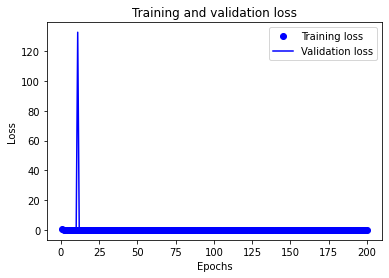

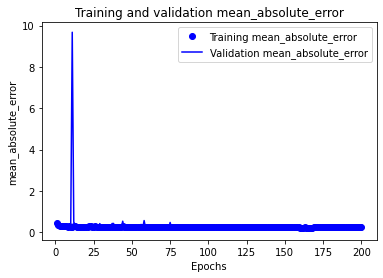

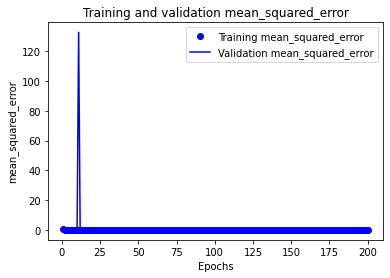

163/163 - 9s - loss: 0.0230 - mse: 0.0230 - mae: 0.1255
[[ 0.07951981  0.17910565  0.06863946  0.13854683]
 [-0.09091633 -0.02432043 -0.25317888  0.24472108]
 [ 0.2873286   0.22853562 -0.20497262  0.13560529]
 ...
 [-0.0768049  -0.10889803 -0.08847125 -0.11867997]
 [-0.0768049  -0.10889803 -0.08847125 -0.11867997]
 [-0.0768049  -0.10889803 -0.08847125 -0.11867997]]


In [ ]:
# *************************************************************
#               Visualization
# *************************************************************
 
# Training loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
# Training accuracy
plt.clf()   # 그래프를 초기화합니다
acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'bo', label='Training mean_absolute_error')
plt.plot(epochs, val_acc, 'b', label='Validation mean_absolute_error')
plt.title('Training and validation mean_absolute_error')
plt.xlabel('Epochs')
plt.ylabel('mean_absolute_error')
plt.legend()
plt.show()
 
# Training accuracy
plt.clf()   # 그래프를 초기화합니다
acc = history.history['mse']
val_acc = history.history['val_mse']
plt.plot(epochs, acc, 'bo', label='Training mean_squared_error')
plt.plot(epochs, val_acc, 'b', label='Validation mean_squared_error')
plt.title('Training and validation mean_squared_error')
plt.xlabel('Epochs')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

# Apply NN to training and test set
scores = model.evaluate(x_train, y_train, verbose=2)
yhat_train = model.predict(x_train)
error = y_train - yhat_train
print(error)

In [ ]:
# ********************************************************
#          LOAD  BEST WEIGHT FROM GOOGLE DRIVE
# ********************************************************
from google.colab import drive
drive.mount('/content/drive')
model.load_weights(filepath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


MSE for test set = 0.019408
MAE for test set = 0.108104


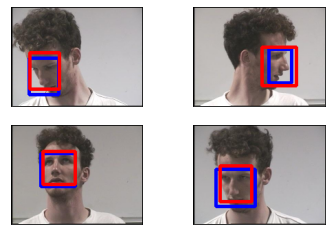

In [ ]:
# ********************************************************
#  Prediction visulaization
# ********************************************************
 
# Test data
yhat_test = model.predict(x_test)
print('MSE for test set = {:f}'.format(
    np.trace(np.matmul((y_test-yhat_test).T,(y_test-yhat_test)))/(outputdim*test_num)))
print('MAE for test set = {:f}'.format(
    np.sum(np.abs(y_test-yhat_test))/(outputdim*test_num)))

Yhat_test = yhat_test*std+mean

fig = plt.figure()
ims = np.random.randint(test_num, size=4)
for i in range(4):
    subplot = fig.add_subplot(2,2, i+1)
    sample_idx = ims[i]
    sample = X_test[sample_idx].copy()  # copy the image to sample ( not to affect the original data )
 
    sample_x1 = int(Y_test[sample_idx][0])
    sample_x2 = int(Y_test[sample_idx][1])
    sample_y1 = int(Y_test[sample_idx][2])
    sample_y2 = int(Y_test[sample_idx][3]) # get box info from Y
 
    cv2.rectangle(sample, (sample_x1, sample_y1), (sample_x2, sample_y2), (255, 0, 0), (3))
  
    sample_x1 = int(Yhat_test[sample_idx][0])
    sample_x2 = int(Yhat_test[sample_idx][1])
    sample_y1 = int(Yhat_test[sample_idx][2])
    sample_y2 = int(Yhat_test[sample_idx][3]) # get box info from Y
 
    cv2.rectangle(sample, (sample_x1, sample_y1), (sample_x2, sample_y2), (0, 0, 255), (3))
 
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(cv2.cvtColor(sample.astype('uint8'), cv2.COLOR_BGR2RGB))
 
plt.show()